In [1]:
import gpn.mlm
import bioframe
import torch
import os
from tqdm import tqdm
from transformers import AutoModel,AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import sys
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES']='3'
model = AutoModel.from_pretrained("gonzalobenegas/gpn-arabidopsis").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("gonzalobenegas/gpn-arabidopsis")
model.eval();

Some weights of the model checkpoint at gonzalobenegas/gpn-arabidopsis were not used when initializing ConvNetModel: ['cls.decoder.3.weight', 'cls.decoder.3.bias', 'cls.decoder.0.bias', 'cls.decoder.2.weight', 'cls.decoder.0.weight', 'cls.decoder.2.bias']
- This IS expected if you are initializing ConvNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
strand = '+'
genome = SeqIO.to_dict(SeqIO.parse("/home/amber/multitask_RNA/data/GPN_plant/TAIR10.fa", format="fasta"))
window_size = 1000000
center = 3566700
seq = genome["5"][center-window_size//2:center+window_size//2].seq
if strand == "+":
    print("Positive strand")
elif strand == "-":
    print("Negative strand")
    print(seq[:10])
    seq = seq.reverse_complement()
    print(seq[:10])
seq = str(seq)

Positive strand


In [3]:
input_ids = tokenizer(seq, return_tensors="pt")["input_ids"]

In [4]:
input_ids = torch.tensor(tokenizer(seq, return_tensors="pt")["input_ids"]).to('cuda')
with torch.no_grad():
    embedding = model(input_ids=input_ids).last_hidden_state[0].cpu().detach().numpy()
print(embedding.shape)

/tmp/ipykernel_280654/2270847760.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(tokenizer(seq, return_tensors="pt")["input_ids"]).to('cuda')


(1000000, 512)


In [5]:
gtf = pd.read_csv(
    #"../../data/vep/tair10.gff",
    #"atRTD3_TS_21Feb22_transfix.gtf",
    "/home/amber/multitask_RNA/data/GPN_plant/Arabidopsis_thaliana.TAIR10.54.chromosome.5.gff3.gz",
    sep='\t', header=None, comment="#",
    names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'],
)
gtf.chrom = gtf.chrom.astype(str)
gtf = gtf[gtf.chrom.isin(["Chr5", "chr5", "5"])]
gtf.shape

(180531, 9)

In [6]:
# To work with the already computed 1Mb embeddings
gtf = gtf[(gtf.start > center-window_size//2) & (gtf.end < center+window_size//2)]
gtf.start -= (center-window_size//2)
gtf.end -= (center-window_size//2)
gtf.shape

(8942, 9)

In [7]:
gtf_exon = gtf[gtf.feature=="exon"]

In [8]:
gtf_exon["transcript_id"] = gtf_exon.attribute.str.split(";").str[0].str.split(":").str[-1]
#gtf_exon["transcript_id"] = gtf_exon.attribute.str.split('"').str[3]

gtf_exon.transcript_id.value_counts()

/tmp/ipykernel_280654/142485091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_exon["transcript_id"] = gtf_exon.attribute.str.split(";").str[0].str.split(":").str[-1]


AT5G12370.1    25
AT5G12370.3    25
AT5G12370.2    25
AT5G10470.2    23
AT5G10470.1    23
               ..
AT5G10040.1     1
AT5G11140.1     1
AT5G01675.2     1
AT5G01635.1     1
AT5G11230.1     1
Name: transcript_id, Length: 574, dtype: int64

In [9]:
import more_itertools

def get_transcript_introns(df_transcript):
    df_transcript = df_transcript.sort_values("start")
    exon_pairs = more_itertools.pairwise(df_transcript.loc[:, ["start", "end"]].values)
    introns = [[e1[1], e2[0]] for e1, e2 in exon_pairs]
    introns = pd.DataFrame(introns, columns=["start", "end"])
    introns["chrom"] = df_transcript.chrom.iloc[0]
    return introns

In [10]:
gtf_introns = gtf_exon.groupby("transcript_id").apply(get_transcript_introns).reset_index().drop_duplicates(subset=["chrom", "start", "end"])
gtf_introns["feature"] = "intron"
gtf_introns

,transcript_id,level_1,start,end,chrom,feature
0,AT5G01675.1,0,106810,107020,5,intron
1,AT5G01675.3,0,106810,112384,5,intron
2,AT5G01675.4,0,107142,112184,5,intron
3,AT5G01675.4,1,112196,112384,5,intron
4,AT5G01675.5,0,107076,112184,5,intron
...,...,...,...,...,...,...
3025,AT5G12850.1,0,989717,990339,5,intron
3026,AT5G12860.1,0,993589,993680,5,intron
3027,AT5G12860.1,1,993901,994131,5,intron
3028,AT5G12860.2,0,993150,993231,5,intron


In [11]:
gtf = pd.concat([gtf, gtf_introns], ignore_index=True)
gtf

,chrom,source,feature,start,end,score,strand,frame,attribute,transcript_id,level_1
0,5,araport11,CDS,115,117,.,+,0,ID=CDS:AT5G09860.2;Parent=transcript:AT5G09860...,NaN,NaN
1,5,araport11,exon,217,300,.,+,.,Parent=transcript:AT5G09860.2;Name=AT5G09860.1...,NaN,NaN
2,5,araport11,CDS,217,300,.,+,0,ID=CDS:AT5G09860.2;Parent=transcript:AT5G09860...,NaN,NaN
3,5,araport11,exon,377,451,.,+,.,Parent=transcript:AT5G09860.2;Name=AT5G09860.1...,NaN,NaN
4,5,araport11,CDS,377,451,.,+,0,ID=CDS:AT5G09860.2;Parent=transcript:AT5G09860...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10474,5,NaN,intron,989717,990339,NaN,NaN,NaN,NaN,AT5G12850.1,0.0
10475,5,NaN,intron,993589,993680,NaN,NaN,NaN,NaN,AT5G12860.1,0.0
10476,5,NaN,intron,993901,994131,NaN,NaN,NaN,NaN,AT5G12860.1,1.0
10477,5,NaN,intron,993150,993231,NaN,NaN,NaN,NaN,AT5G12860.2,0.0


In [12]:
gtf.feature.value_counts()

exon               3606
CDS                3242
intron             1537
five_prime_UTR      641
three_prime_UTR     560
mRNA                521
gene                280
ncRNA_gene           41
lnc_RNA              33
tRNA                  7
miRNA                 6
ncRNA                 2
snoRNA                2
snRNA                 1
Name: feature, dtype: int64

In [13]:
gtf.chrom = gtf.chrom.astype(str)
gtf.start = gtf.start.astype(int)
gtf.end = gtf.end.astype(int)


In [14]:
features_of_interest = ['CDS', 'five_prime_UTR', 'three_prime_UTR', 'intron']

In [15]:
W = 30#50
windows = pd.DataFrame(dict(start=np.arange(0+10000, window_size-W-10000, W)))
windows["end"] = windows.start + W
windows["chrom"] = gtf.chrom.iloc[0] #"5"

for f in features_of_interest:
    windows = bioframe.coverage(windows, gtf[gtf.feature==f])
    windows.rename(columns=dict(coverage=f), inplace=True)
windows

,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron
0,10000,10030,5,30,0,0,0
1,10030,10060,5,30,0,0,0
2,10060,10090,5,30,0,0,0
3,10090,10120,5,16,0,0,14
4,10120,10150,5,0,0,0,30
...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30
32662,989860,989890,5,0,0,0,30
32663,989890,989920,5,0,0,0,30
32664,989920,989950,5,0,0,0,30


In [16]:
windows["Region"]= np.nan
windows.loc[windows[features_of_interest].sum(axis=1)==0, "Region"] = "Intergenic"
windows.loc[(windows.CDS==0)&(windows.five_prime_UTR==0)&(windows.three_prime_UTR==0)&(windows.intron==W), "Region"] = "Intron"
windows.loc[(windows.CDS==W)&(windows.five_prime_UTR==0)&(windows.three_prime_UTR==0)&(windows.intron==0), "Region"] = "CDS"
windows.loc[(windows.CDS==0)&(windows.five_prime_UTR==W)&(windows.three_prime_UTR==0)&(windows.intron==0), "Region"] = "5' UTR"
windows.loc[(windows.CDS==0)&(windows.five_prime_UTR==0)&(windows.three_prime_UTR==W)&(windows.intron==0), "Region"] = "3' UTR"
windows.Region.value_counts()

Intergenic    9056
CDS           8953
Intron        6052
3' UTR        2011
5' UTR        1418
Name: Region, dtype: int64

In [17]:
windows.dropna(inplace=True)
windows.shape

(27490, 8)

## Cluster by sequence only

In [46]:
dna_dict = {'A':0,"C":1,"G":2,"T":3}
onehot = np.zeros((len(seq),4))
for i in range(0,len(seq)):
    base = seq[i]
    onehot[i,dna_dict[base]] = 1


In [47]:
#1*120 vector
onehot_cols = np.arange(onehot.shape[1]*30)
windows.loc[:, onehot_cols] = windows.apply(
    lambda row: onehot[row.start:row.end].flatten(),
    axis=1,
    result_type="expand",
)


,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,1,...,110,111,112,113,114,115,116,117,118,119
0,10000,10030,5,30,0,0,0,CDS,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10030,10060,5,30,0,0,0,CDS,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10060,10090,5,30,0,0,0,CDS,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10120,10150,5,0,0,0,30,Intron,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,10150,10180,5,0,0,0,30,Intron,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30,Intron,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
32662,989860,989890,5,0,0,0,30,Intron,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
32663,989890,989920,5,0,0,0,30,Intron,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32664,989920,989950,5,0,0,0,30,Intron,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
# 1*4 vector
onehot_cols = np.arange(onehot.shape[1])
windows.loc[:, onehot_cols] = windows.apply(
    lambda row: onehot[row.start:row.end].sum(axis=0),
    axis=1,
    result_type="expand",
)

,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,1,2,3,UMAP1,UMAP2
0,10000,10030,5,30,0,0,0,CDS,7.0,3.0,14.0,6.0,5.225390,5.390456
1,10030,10060,5,30,0,0,0,CDS,7.0,10.0,5.0,8.0,23.380720,-8.457633
2,10060,10090,5,30,0,0,0,CDS,12.0,3.0,7.0,8.0,-12.641869,4.307458
4,10120,10150,5,0,0,0,30,Intron,8.0,6.0,1.0,15.0,6.106566,-0.237007
5,10150,10180,5,0,0,0,30,Intron,5.0,3.0,5.0,17.0,16.764282,-0.760860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30,Intron,4.0,3.0,8.0,15.0,4.124409,22.314686
32662,989860,989890,5,0,0,0,30,Intron,6.0,4.0,1.0,19.0,6.141224,-0.645850
32663,989890,989920,5,0,0,0,30,Intron,8.0,1.0,6.0,15.0,11.364924,8.575588
32664,989920,989950,5,0,0,0,30,Intron,7.0,4.0,5.0,14.0,13.237679,22.609470


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from umap import UMAP
projector = Pipeline([
    ("scaler", StandardScaler()),  # not sure it's a good idea. yeah, they have very different variances.
    #("pca", PCA(n_components=10)),
    ("umap", UMAP(n_components=2, n_neighbors=15, random_state=42, min_dist=0.1)),  # default n_neighbors works well
])
windows[["UMAP1", "UMAP2"]] = projector.fit_transform(windows[onehot_cols])

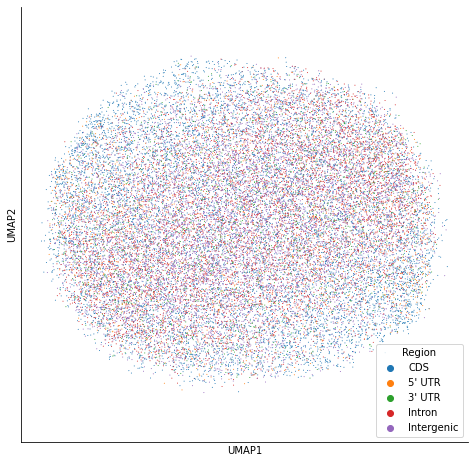

In [49]:

region_order = ["CDS", "5' UTR", "3' UTR", "Intron", "Intergenic"]


plt.figure(figsize=(8, 8))
g = sns.scatterplot(
    data=windows,
    x="UMAP1",
    y="UMAP2",
    hue="Region",
    hue_order=region_order,
    s=1,
    linewidth=0,
    palette="tab10",
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');

## Representation clustering

In [18]:
embedding.shape

(1000000, 512)

In [19]:
embedding_cols = np.arange(embedding.shape[1])
windows.loc[:, embedding_cols] = windows.apply(
    lambda row: embedding[row.start:row.end].sum(axis=0),
    axis=1,
    result_type="expand",
)
windows


,start,end,chrom,CDS,five_prime_UTR,three_prime_UTR,intron,Region,0,1,...,502,503,504,505,506,507,508,509,510,511
0,10000,10030,5,30,0,0,0,CDS,27.626339,-53.767609,...,-38.075428,-75.943382,54.075245,-20.234186,-61.719131,92.016708,-24.100309,-61.942417,-49.264122,-93.240166
1,10030,10060,5,30,0,0,0,CDS,-39.141232,-41.850716,...,-5.567705,-87.903618,58.342346,-17.471008,-24.141743,748.142639,-42.149223,-128.474533,72.228378,-85.470589
2,10060,10090,5,30,0,0,0,CDS,19.972961,-46.468342,...,-31.330311,-85.139656,35.052731,12.497384,-64.843559,183.960358,2.615798,-19.489944,99.696411,-100.538414
4,10120,10150,5,0,0,0,30,Intron,49.682190,-55.431889,...,44.263596,-87.114120,24.428411,-26.127140,-42.976395,368.174286,72.945023,-105.453941,-47.947220,-80.926338
5,10150,10180,5,0,0,0,30,Intron,15.039381,-26.354967,...,12.250834,-72.835495,42.626938,-36.205254,-24.661232,105.161995,135.158112,-57.117783,-38.403362,-54.208069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,5,0,0,0,30,Intron,-67.188538,-56.954838,...,-38.851452,-83.878517,-31.695383,-42.392601,-40.135296,85.039452,60.278976,-91.068962,-93.531120,-63.879993
32662,989860,989890,5,0,0,0,30,Intron,-45.495232,-65.460663,...,0.890435,-53.162323,19.899101,-58.705055,-38.811424,208.327835,106.285545,-98.247208,-66.585381,-57.134743
32663,989890,989920,5,0,0,0,30,Intron,-82.799385,-85.416649,...,-10.388781,-60.707790,-22.989414,-46.674793,-81.941231,-71.806816,82.084320,-126.271339,-106.511490,-75.256897
32664,989920,989950,5,0,0,0,30,Intron,-60.004391,-48.420189,...,-7.752959,-56.443069,-12.921184,-32.744305,-47.002823,177.287552,93.448021,-94.950378,-88.899544,-80.891373


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from umap import UMAP
projector = Pipeline([
    ("scaler", StandardScaler()),  # not sure it's a good idea. yeah, they have very different variances.
    #("pca", PCA(n_components=10)),
    ("umap", UMAP(n_components=2, n_neighbors=15, random_state=42, min_dist=0.1)),  # default n_neighbors works well
])
windows[["UMAP1", "UMAP2"]] = projector.fit_transform(windows[embedding_cols])

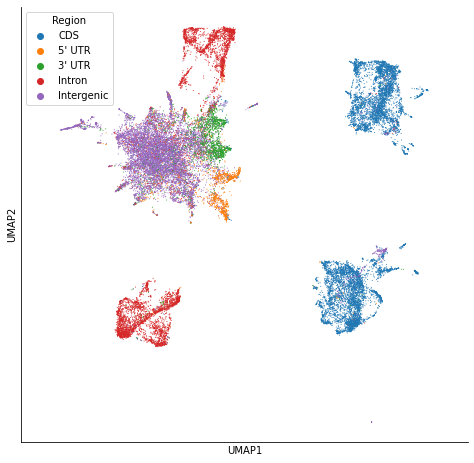

In [21]:

region_order = ["CDS", "5' UTR", "3' UTR", "Intron", "Intergenic"]


plt.figure(figsize=(8, 8))
g = sns.scatterplot(
    data=windows,
    x="UMAP1",
    y="UMAP2",
    hue="Region",
    hue_order=region_order,
    s=1,
    linewidth=0,
    palette="tab10",
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');